In [1]:
# Sitting up the environnement
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold, learning_curve, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc

from sklearn.preprocessing import StandardScaler, LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

Loading data

In [2]:
site_traffic_df = pd.read_csv("recipe_site_traffic.csv", )
site_traffic_df.sample(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
350,351,45.62,15.34,3.27,2.16,Breakfast,6,High
777,778,47.89,17.17,9.89,0.89,Beverages,6,NaN
184,185,62.59,23.96,6.25,30.83,One Dish Meal,6,NaN
576,577,551.30,126.97,1.51,9.77,Breakfast,4,NaN
296,297,487.86,142.22,5.21,1.09,Potato,6,High
736,737,70.53,17.09,10.64,0.87,Beverages,6,NaN
649,650,338.77,13.88,1.69,0.24,Beverages,2,NaN
442,443,108.28,60.94,7.79,55.46,One Dish Meal,4,High
187,188,NaN,NaN,NaN,NaN,Pork,4,High
545,546,NaN,NaN,NaN,NaN,Chicken Breast,6,High


Data info

In [3]:
site_traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


First things first, we can see that there is some data missing in calories, carbohydrate, sugar, protein and high_traffic columns. Second, category, servings and high_traffic columns are pandas objects (categorical).
According to the product manager 'servings' must be numerical so let's do the conversion.

1. ## Data Preprocessing

#### Dealing with "servings" column

Converting servings to integers as required

In [4]:
site_traffic_df['servings'].unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

As we can see, there are some elements in the servings column that must be processed in the form of {integer+"as a snack"}.

In [5]:
site_traffic_df['servings'] = pd.to_numeric(site_traffic_df['servings'].str.split().str[0], errors='coerce')

Let's check if the column's data type has changed to numerical (integer)

In [6]:
site_traffic_df['servings'].dtype

dtype('int64')

In [7]:
site_traffic_df['servings'].unique()

array([6, 4, 1, 2])

Okay, moving on..

#### Dealing with "category" column

What categories do we have ?

In [8]:
category_list = list(site_traffic_df['category'].unique())
print(category_list, "\nN°categories =",len(category_list))

['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal', 'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat', 'Dessert'] 
N°categories = 11


Comparing with the list provided by the manager

In [9]:
managers_category_list = ['Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken', 'Pork', 'Dessert', 'Breakfast','One Dish Meal']
[print(cat) for cat in category_list if cat not in managers_category_list]

Chicken Breast


[None]

We can classify 'Chicken Breast' with the 'Chicken' category

In [10]:
site_traffic_df['category'] = site_traffic_df['category'].str.replace('Chicken Breast','Chicken')

Let's check now if we have the same categories as the manager's

In [11]:
print(site_traffic_df['category'].unique())
print(site_traffic_df['category'].unique().shape)

['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken'
 'Lunch/Snacks' 'Vegetable' 'Meat' 'Dessert']
(10,)


Great ! Moving on..

#### Dealing with "high_trafic" column

We only have 'High' traffic or null values in this column

In [12]:
site_traffic_df['high_traffic'].unique()

array(['High', nan], dtype=object)

In [13]:
missing_high_traffic = site_traffic_df['high_traffic'].isnull().sum()
missing_high_traffic

373

In [14]:
ratio = missing_high_traffic/len(site_traffic_df['high_traffic'])*100
ratio

39.38753959873284

<Axes: xlabel='count', ylabel='high_traffic'>

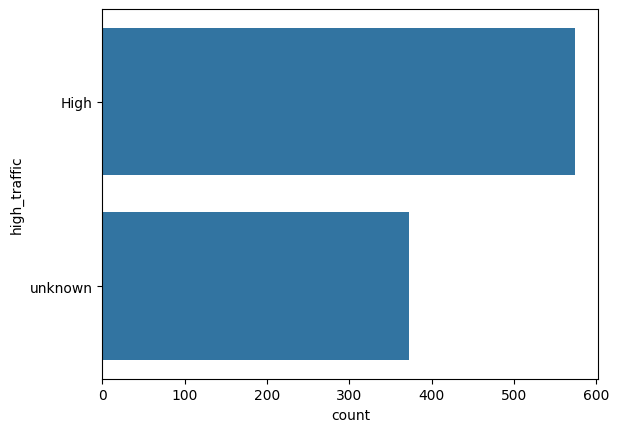

In [66]:
sns.countplot(site_traffic_df['high_traffic'])

About 39% of the data is missing in the 'high_traffic' column. At this stage we cannot define null values as 'High' or 'Not High' simply because the recipes aren't shown on the site yet (or shown but no high traffic was observed and no data was delivered, let's just call it unknown). Having a set of recipes we will be predicting the ones that lead to high traffic on the platform.

In [15]:
site_traffic_df['high_traffic'] = site_traffic_df['high_traffic'].fillna('unknown')
site_traffic_df['high_traffic'].sample(10)

277    unknown
445       High
647       High
491    unknown
324       High
826       High
595       High
480    unknown
842       High
247    unknown
Name: high_traffic, dtype: object

#### Dealing with missing values

For the rows that have null values for 'calories', 'carbohydrate', 'sugar' and 'protein' at once, it is better to drop them simply because without them we cannot define a recipe (and setting them to 0 or mean of data is not relevant).

In [16]:
columns_of_interest = ['calories', 'carbohydrate', 'sugar', 'protein']
missing_values_df = site_traffic_df[site_traffic_df[columns_of_interest].isnull().all(axis=1)]
missing_values_df.sample(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
297,298,NaN,NaN,NaN,NaN,Lunch/Snacks,6,unknown
674,675,NaN,NaN,NaN,NaN,Pork,4,High
23,24,NaN,NaN,NaN,NaN,Meat,2,unknown
530,531,NaN,NaN,NaN,NaN,Vegetable,1,High
89,90,NaN,NaN,NaN,NaN,Pork,6,High
212,213,NaN,NaN,NaN,NaN,Dessert,4,High
851,852,NaN,NaN,NaN,NaN,Lunch/Snacks,4,High
608,609,NaN,NaN,NaN,NaN,Chicken,4,unknown
911,912,NaN,NaN,NaN,NaN,Dessert,6,High
405,406,NaN,NaN,NaN,NaN,Vegetable,4,High


We count 52 observations where 'calories', 'carbohydrate', 'sugar' and 'protein' columns all have null values at once. Now we can drop the corresponding rows and we're sure that we're dropping only rows where we have null values for the four items all at once.

In [17]:
site_traffic_df_cleaned = site_traffic_df.copy()
site_traffic_df_cleaned = site_traffic_df_cleaned.dropna(subset=columns_of_interest, how='all')
site_traffic_df_cleaned.sample(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
694,695,1348.40,152.24,0.15,2.56,One Dish Meal,2,High
355,356,1337.71,3.84,8.48,0.95,Vegetable,6,High
170,171,431.28,14.69,4.17,32.79,One Dish Meal,2,High
114,115,177.84,10.67,2.21,3.02,Lunch/Snacks,2,High
599,600,902.54,6.50,7.17,41.60,Pork,2,High
100,101,266.41,58.44,4.19,10.96,Chicken,4,unknown
282,283,31.65,5.42,6.69,13.25,Vegetable,6,High
403,404,126.96,19.11,18.17,0.18,Beverages,4,unknown
482,483,920.73,9.91,38.66,0.36,Dessert,4,High
644,645,26.16,32.73,1.32,0.73,Potato,2,High


Now that we have a clean dataset, let's explore it !

In [190]:
# Quick check
site_traffic_df_cleaned['high_traffic'].value_counts('unknown')*100

high_traffic
High       59.776536
unknown    40.223464
Name: proportion, dtype: float64

40% of the data is still to predict (unknown).

2. ## Data Exploration

#### Dataset Description

In [20]:
site_traffic_df_cleaned.describe()

,recipe,calories,carbohydrate,sugar,protein,servings
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,473.652514,435.939196,35.069676,9.046547,24.149296,3.458101
std,272.763283,453.020997,43.949032,14.679176,36.369739,1.735979
min,2.000000,0.140000,0.030000,0.010000,0.000000,1.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000,2.000000
50%,475.000000,288.550000,21.480000,4.550000,10.800000,4.000000
75%,708.500000,597.650000,44.965000,9.800000,30.200000,4.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000


Interquartile Range (IQR)

In [21]:
iqr = site_traffic_df_cleaned['calories'].quantile(0.75) - site_traffic_df_cleaned['calories'].quantile(0.25)

# just checking if we have the same quantiles in the description table
print("First Quantile:", site_traffic_df_cleaned['calories'].quantile(0.25), "Third Quantile", site_traffic_df_cleaned['calories'].quantile(0.75))

# Interquantile Range
print("IQR =", iqr)

First Quantile: 110.43 Third Quantile 597.65
IQR = 487.21999999999997


While the columns for 'recipe' and 'servings' may offer limited insight, the remaining columns in the dataset provide more substantial information for analysis.
I can read the results but the table is more insightful.
Let me analyze the 'calories' for you :
- Skewness: The median (288.55) being less than the mean (435.94) suggests a positively skewed distribution. This skewness is further indicated by the fact that the IQR (487.22) is larger than the mean.
- Variability: The large difference between the IQR and the median indicates substantial variability in the middle 50% of the dataset.
- Outliers: The large difference between the mean and the median, as well as the large IQR, suggest the possible presence of outliers on the higher end of the distribution. These outliers are likely influencing the mean and contributing to the positively skewed distribution.
- Central Tendency: The fact that the median is substantially lower than the mean indicates that the distribution is heavily influenced by the higher values, pulling the mean upwards. In this case, the median may be a more representative measure of central tendency, especially in the presence of outliers.

#### Some visualizations

To validate the previous interpretations let's visualize data.

<Axes: ylabel='calories'>

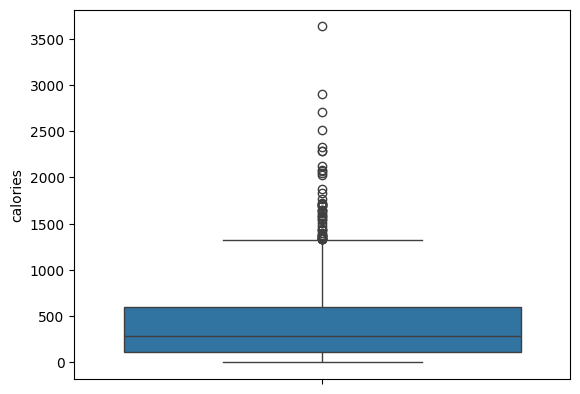

In [22]:
sns.boxplot(data=site_traffic_df_cleaned['calories'])

Most of 'calories' data is concentrated in the range [100,600]. Here we can observe the presence of outliers that could affect our analysis.

[]

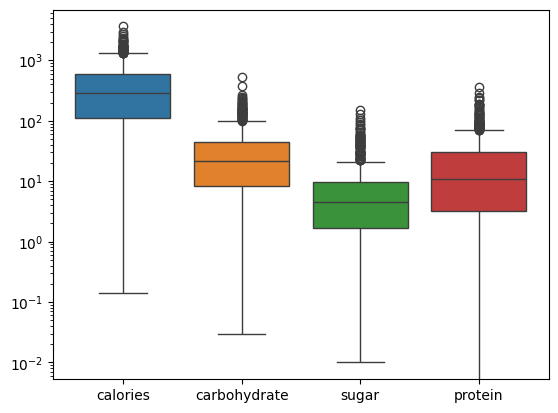

In [27]:
# Boxplot for all recipe elements
nutrition_cols = site_traffic_df_cleaned.columns[1:-3]
sns.boxplot(data=site_traffic_df_cleaned[nutrition_cols])
plt.semilogy()

We can see the presence of outliers also for the other items (recipe and servings are not representative).

Now let's verify the distribution skewness of 'calories'

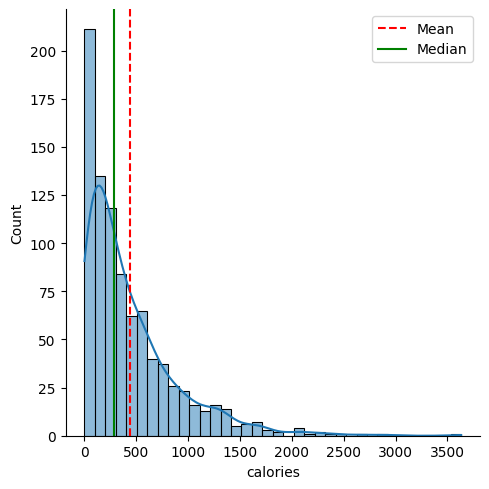

In [24]:
# plotting calories distribution
sns.displot(site_traffic_df_cleaned['calories'], kde='true')

# vertical red line at the mean
plt.axvline(site_traffic_df_cleaned['calories'].mean(), color='r', linestyle='--', label='Mean')

# vertical green line at the median
plt.axvline(site_traffic_df_cleaned['calories'].median(), color='g', linestyle='-', label='Median')

# legend
plt.legend()

# display
plt.show()

In [25]:
# skewness calculation
skewness = site_traffic_df_cleaned['calories'].skew()
print("Skewness:", skewness)

Skewness: 2.036150959685193


The value of skewness is greater than 1, this distribution is highly skewed to the right.

#### Relationship between two variables

Out of curiosity, let's plot the correlation matrix of nutritions.

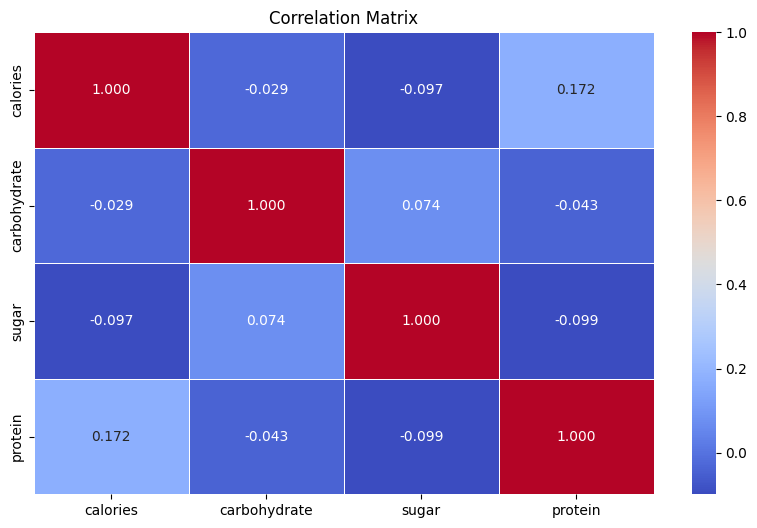

In [31]:
correlation_matrix = site_traffic_df_cleaned[nutrition_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In this matrix we can see if we have positive or negative correlation between two variables (calories vs protein, sugar vs carbohydrate, sugar vs calories, etc.), it is important to note that this doesn't prove any relationship between these variables because one variable (calories for example) can depend on all the other variables and not only one.

Now a pairplot to analyze the distribution of each item and the distribution of each correlation between the varaibles.

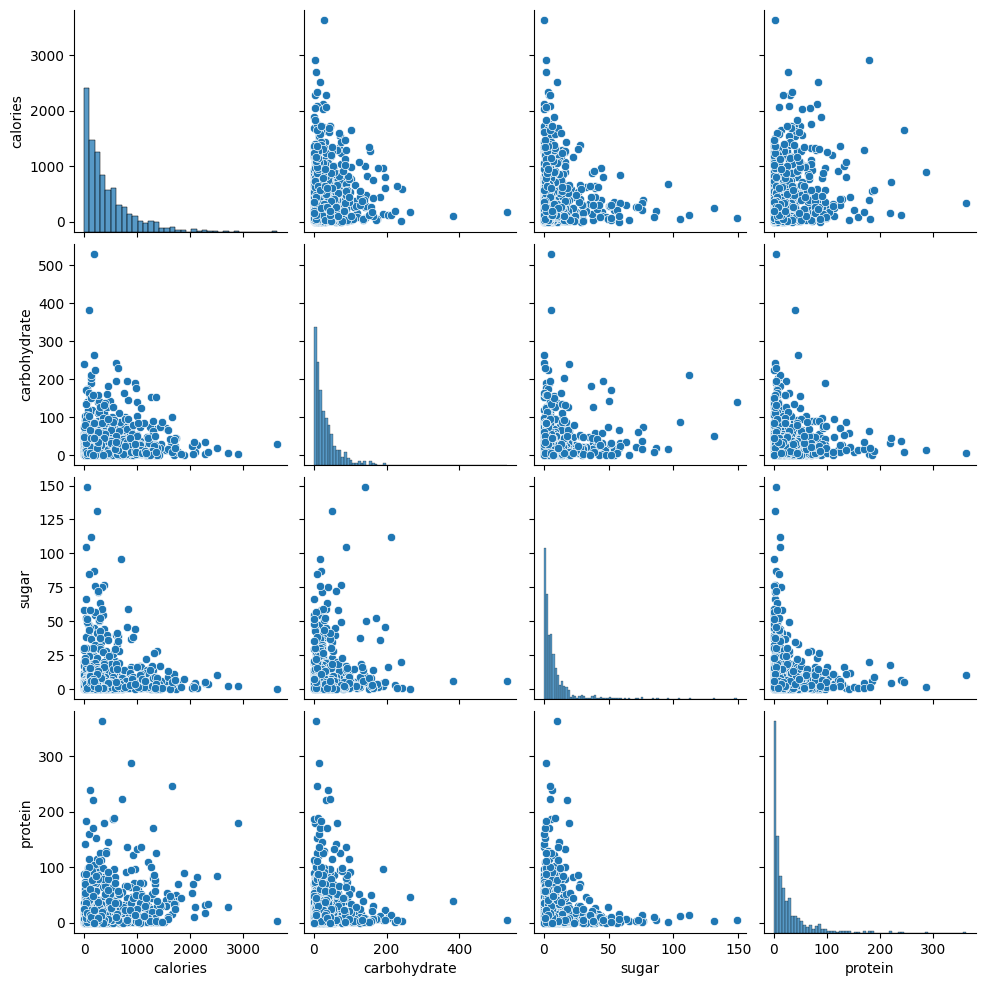

In [32]:
sns.pairplot(site_traffic_df_cleaned[nutrition_cols])

All recipes are highly skewed. This skewness is due to the presence of outliers. For example in one standard serving it is highly unlikely to have 1550.2 calories for a chicken breast !

And because i already tried some techniques like logarithm to induce normality that didn't work, i'm going to inspect data to remove some outliers while being causious about data loss.

#### Relationship between nutrition components and categories for different servings

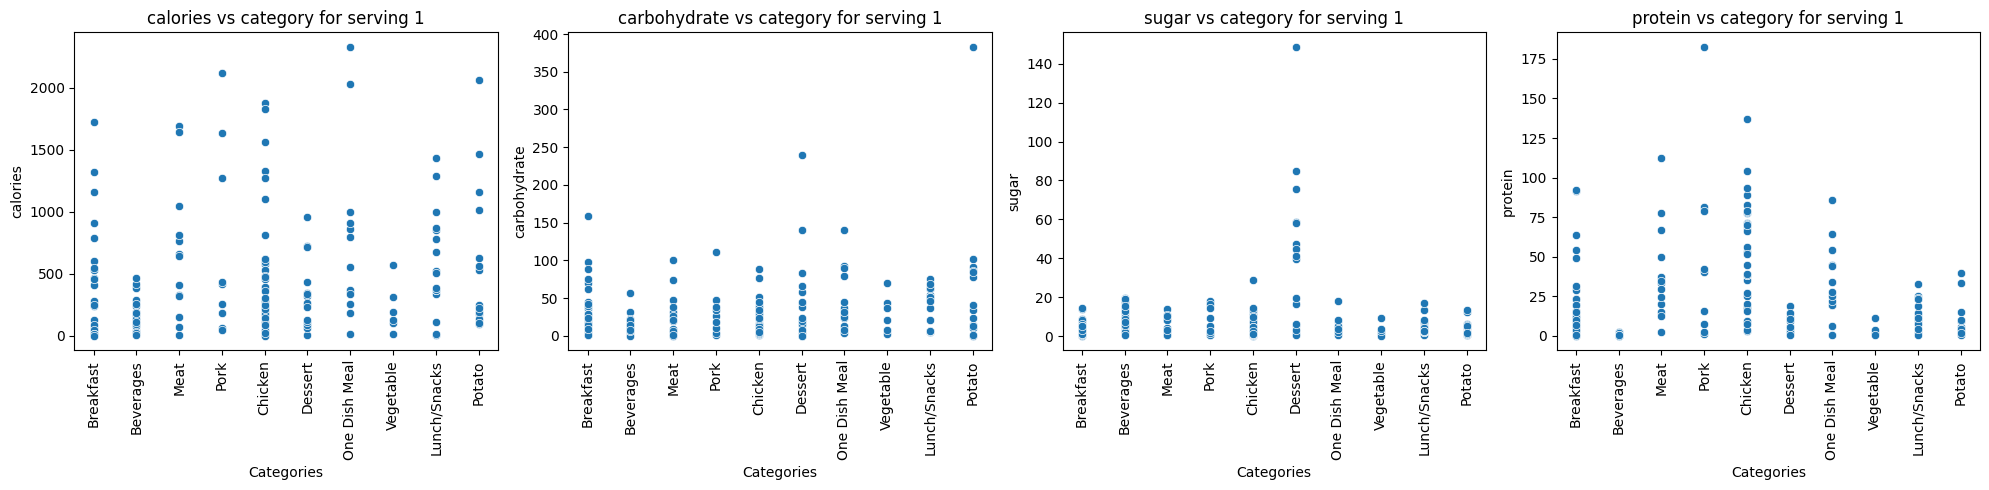

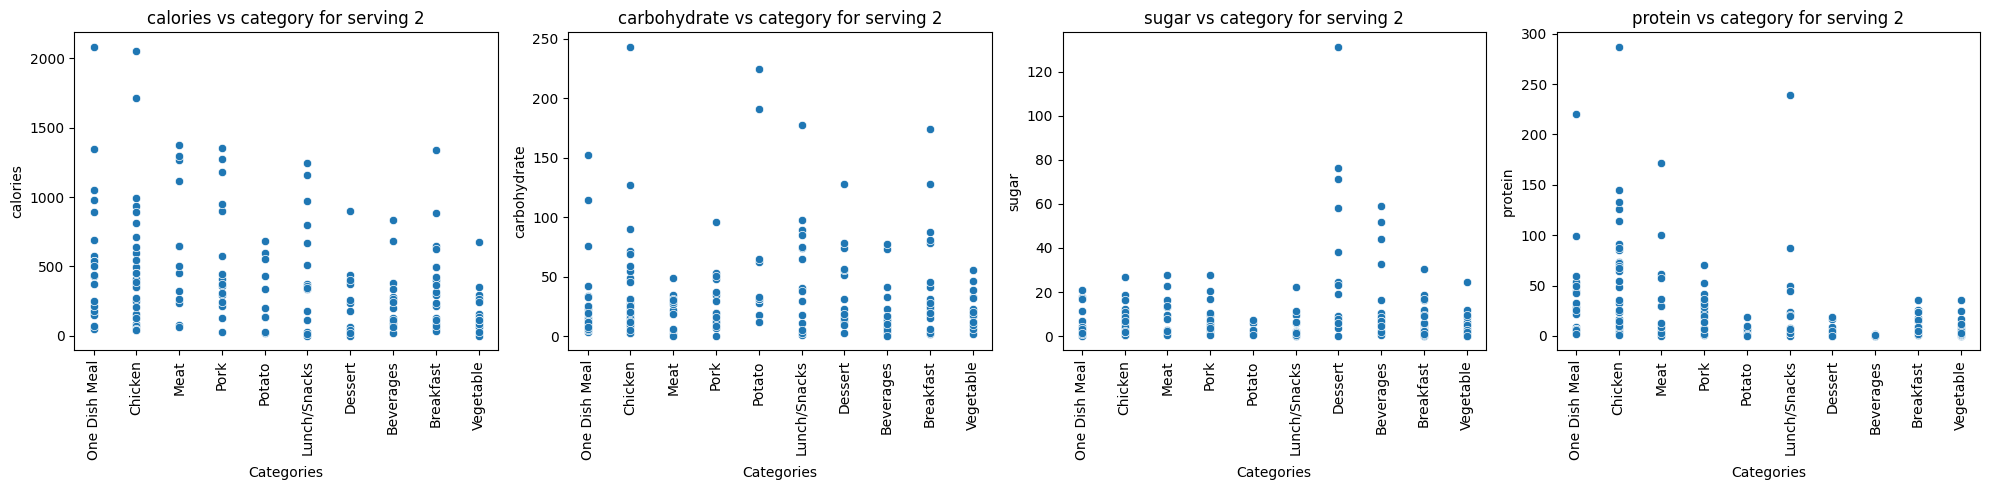

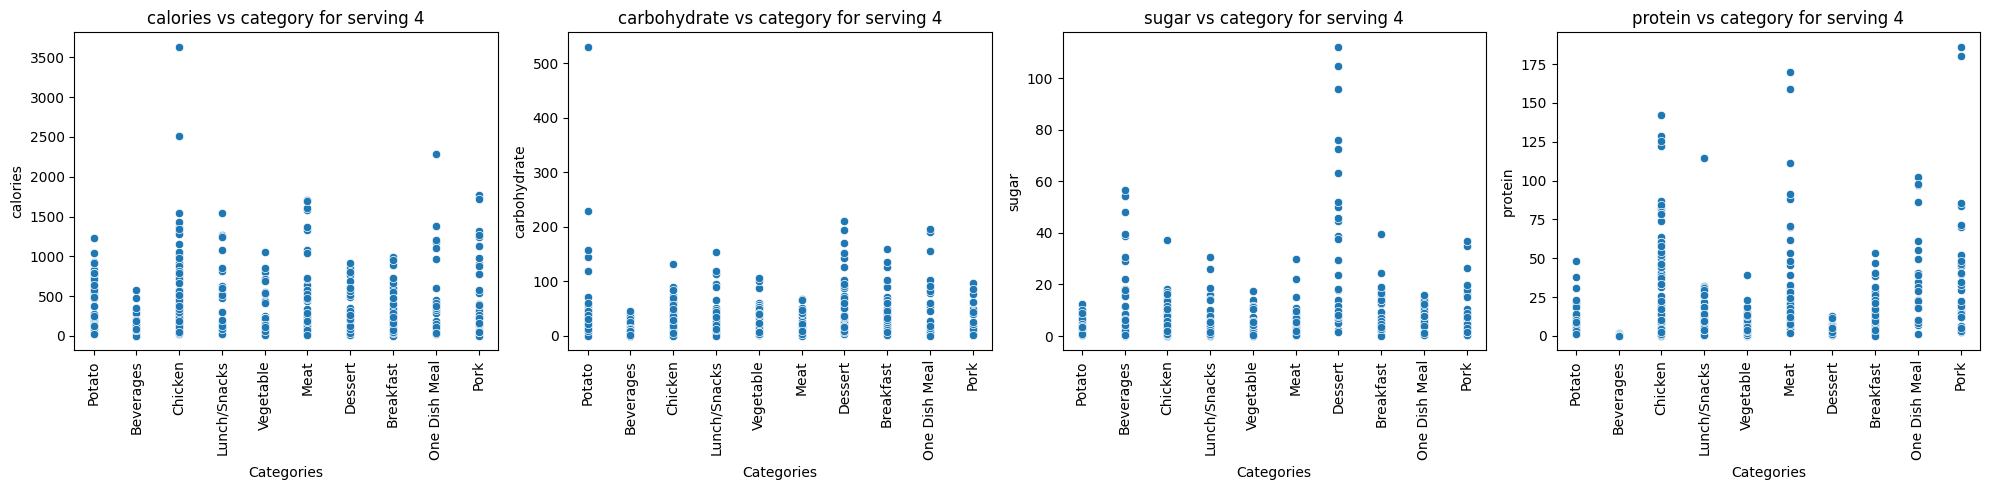

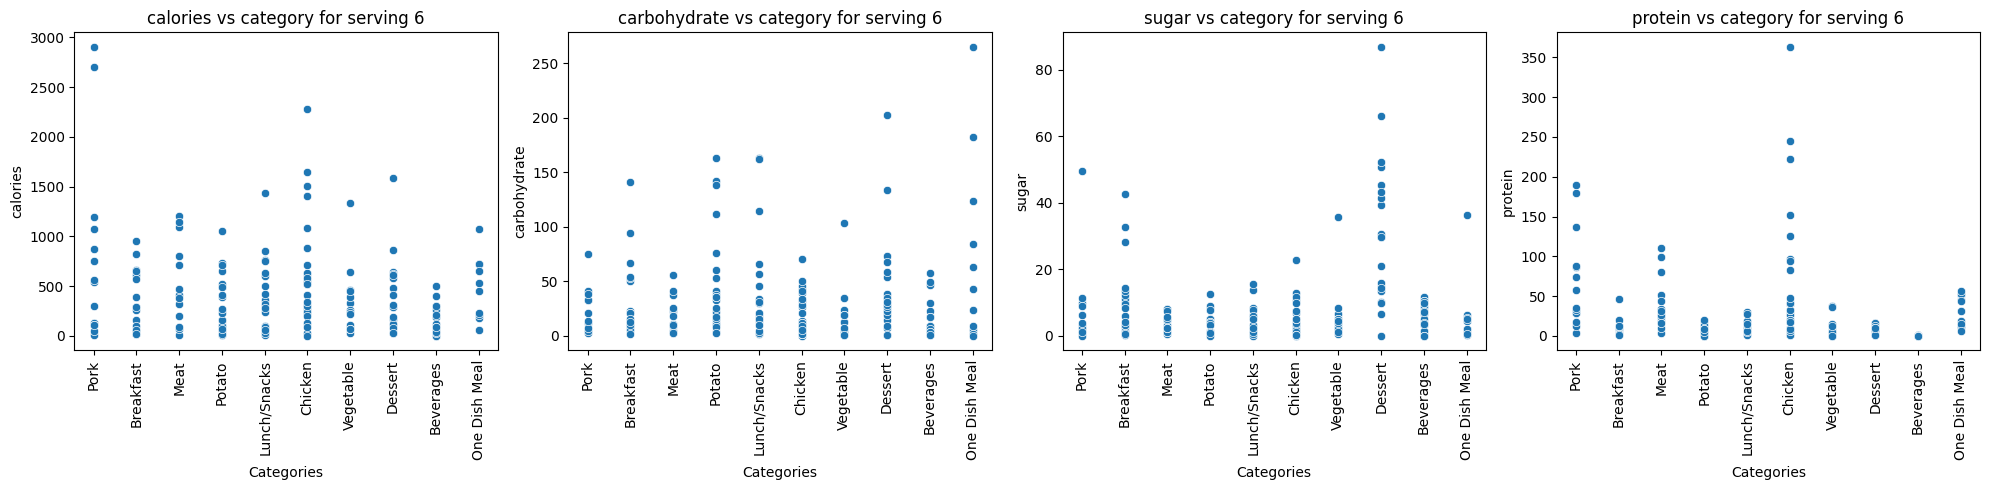

In [40]:
# Plotting macronutrients as function of category for available servings
for j in [1,2,4,6]:
    filterj = site_traffic_df_cleaned[site_traffic_df_cleaned['servings']==j]
    columns_to_plot = filterj[['calories', 'carbohydrate', 'sugar', 'protein']]

    # figure and subplots
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # scatter plot in a separate subplot
    for i, col in enumerate(columns_to_plot):
        sns.scatterplot(x=filterj['category'], y=filterj[col], ax=axes[i])
        axes[i].set_xlabel('Categories')
        axes[i].set_ylabel(str(col))
        axes[i].set_title(f'{col} vs category for serving {j}')
        axes[i].tick_params(axis='x', rotation=90)  # Rotate x-axis tick labels if needed

    # layout adjusting and plot display
    plt.tight_layout()
    plt.show()

In [49]:
from scipy.stats import zscore

df = site_traffic_df_cleaned.copy()
z_scores = df[nutrition_cols].apply(zscore)

# Define a threshold for identifying outliers
# For example, consider data points with Z-score greater than 3 as outliers
threshold = 3

# Find outliers
outliers = (z_scores > threshold) | (z_scores < -threshold)
outliers.sample(50)

,calories,carbohydrate,sugar,protein
318,False,False,False,False
907,True,False,False,False
438,False,False,False,False
226,True,False,False,False
885,False,False,False,False
847,False,False,False,False
95,False,False,True,False
436,False,False,False,False
444,False,False,False,False
38,False,False,False,False


Seems to be working well.

In [55]:
df_without_outliers = df.mask(outliers).dropna()

In [59]:
df_without_outliers.head(20)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,unknown
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,unknown
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High
6,7,183.94,47.95,9.75,46.71,Chicken,4,unknown
7,8,299.14,3.17,0.40,32.40,Lunch/Snacks,4,unknown
8,9,538.52,3.78,3.37,3.79,Pork,6,High
9,10,248.28,48.54,3.99,113.85,Chicken,2,unknown
10,11,170.12,17.63,4.10,0.91,Beverages,1,unknown


In [192]:
df_without_outliers['high_traffic'].value_counts('unknown')*100

high_traffic
High       58.837772
unknown    41.162228
Name: proportion, dtype: float64

In [60]:
# unusual_recipes = [22, 30, 56, 64, 71, 72, 98, 125, 168, 207, 227, 240, 262, 291, 308, 314, 317, 323, 332, 343, 350, 356, 357, 384, 398, 427, 
#            451, 454, 468, 488, 530, 541, 549, 576, 591, 617, 637, 666, 682, 696, 722, 738, 739, 782, 783, 862, 888, 908, 926, 940]
# unusual_df = site_traffic_df_cleaned[site_traffic_df_cleaned['recipe'].apply(lambda x: x in unusual_recipes)]
# unusual_df

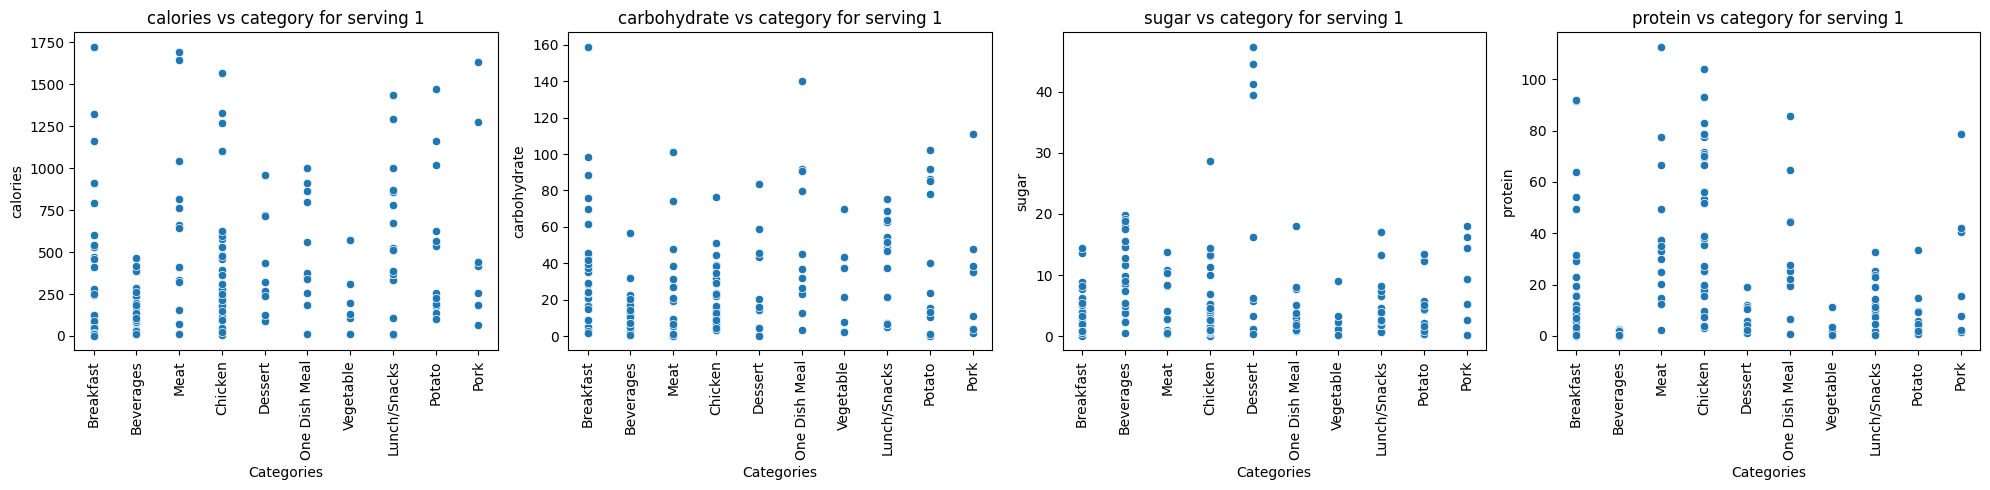

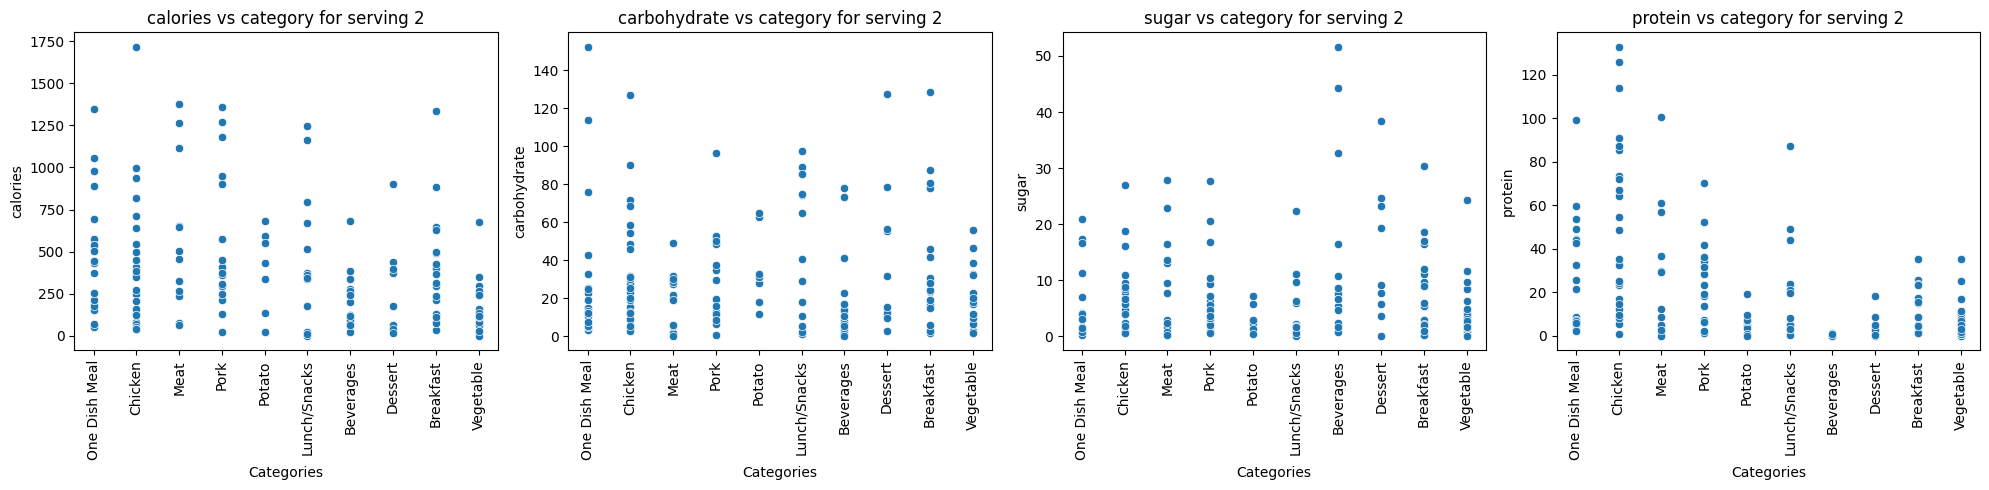

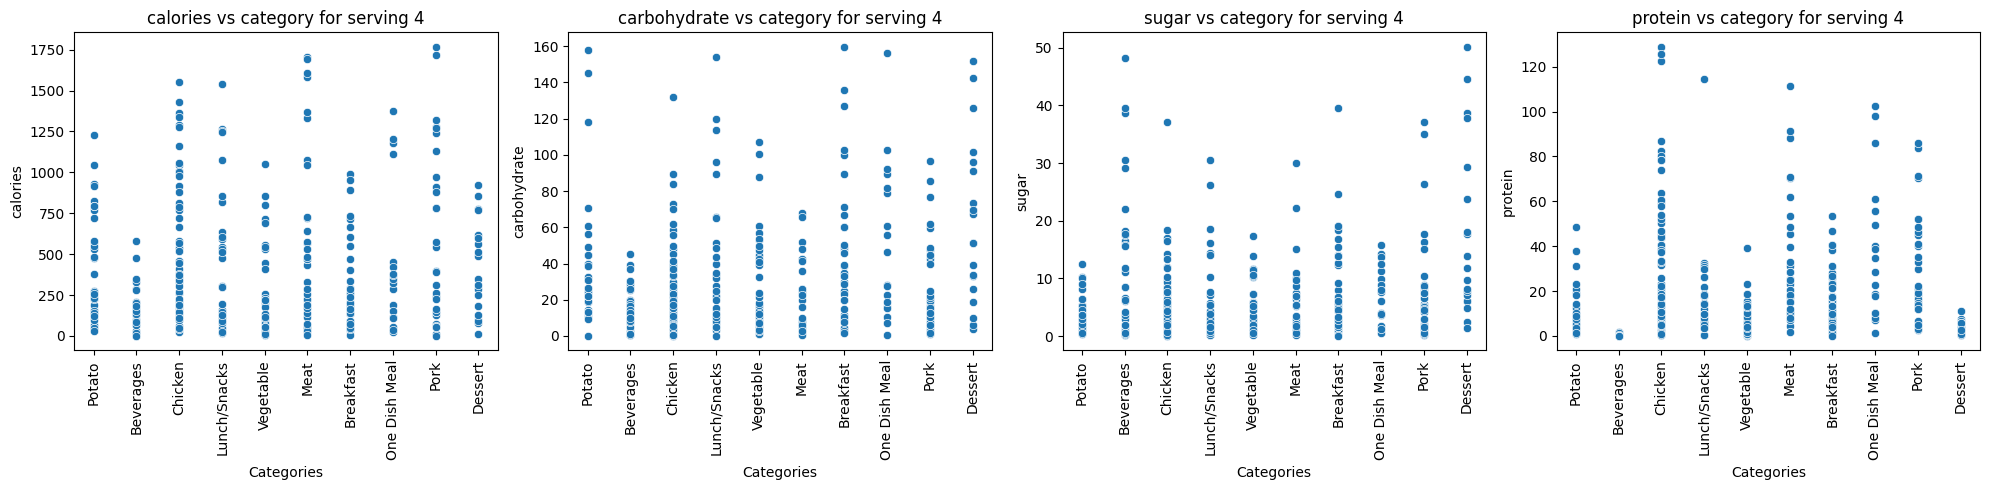

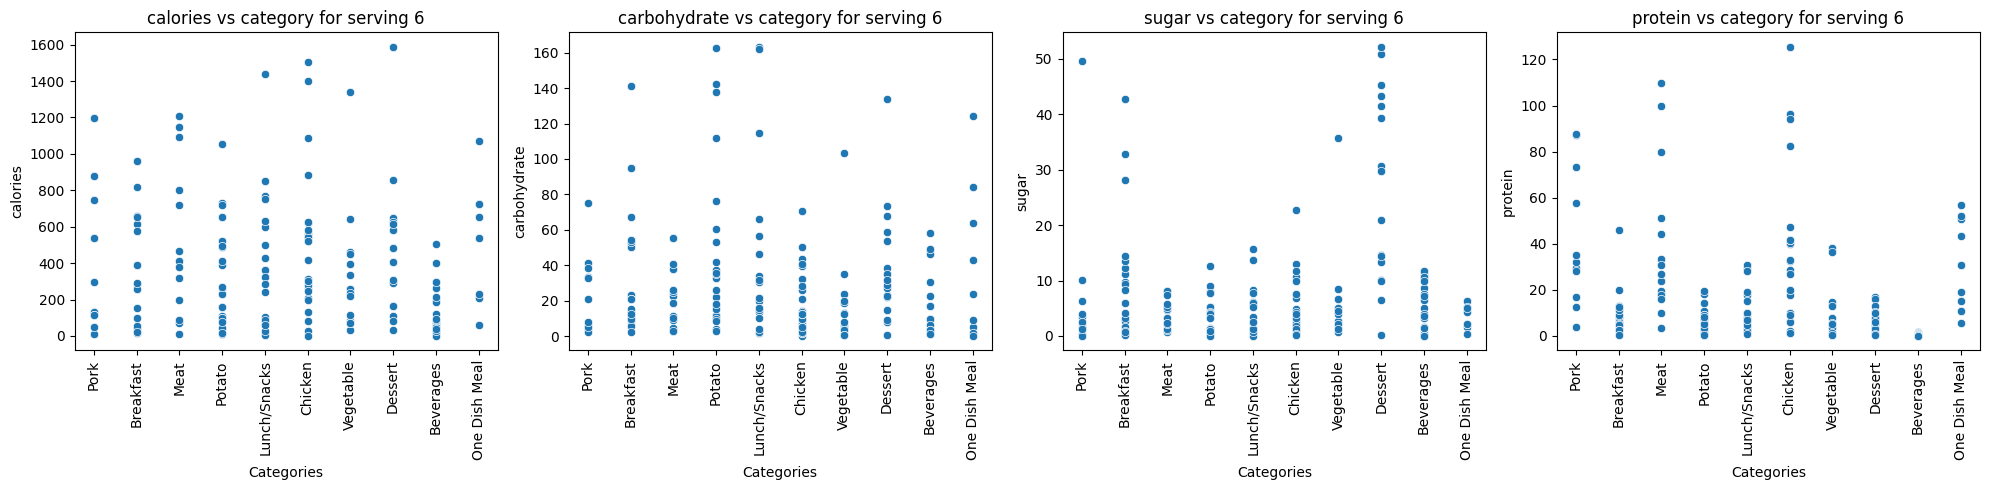

In [61]:
# Plotting macronutrients as function of category for available servings
for j in [1,2,4,6]:
    filterj = df_without_outliers[df_without_outliers['servings']==j]
    columns_to_plot = filterj[['calories', 'carbohydrate', 'sugar', 'protein']]

    # figure and subplots
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # scatter plot in a separate subplot
    for i, col in enumerate(columns_to_plot):
        sns.scatterplot(x=filterj['category'], y=filterj[col], ax=axes[i])
        axes[i].set_xlabel('Categories')
        axes[i].set_ylabel(str(col))
        axes[i].set_title(f'{col} vs category for serving {j}')
        axes[i].tick_params(axis='x', rotation=90)  # Rotate x-axis tick labels if needed

    # layout adjusting and plot display
    plt.tight_layout()
    plt.show()

I'm going to use a scaler that is robust to outliers in order to mitigate their effect.

In [62]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()

# 3. Model Developement

Traffic as a variable in this universe can take a binary state : {'High', 'Unknown'}. As a result, we can use logistic regression to classify traffic. Other models like Decision Trees, Random Forests, Support Vector Machines (SVM), and Gradient Boosting Machines (GBM) also can be used. I personnaly prefer to apply model selection to select the most suitable model for any problem.

Before implementing any predictive model we must convert categorical data to numerical. I will be using a Label Encoder for this purpose.

In [67]:
label_encoder = LabelEncoder()

In [135]:
site_traffic_df_encoded = df_without_outliers.copy()
site_traffic_df_encoded['category_encoded'] = label_encoder.fit_transform(site_traffic_df_encoded['category'])
site_traffic_df_encoded['traffic_encoded'] = site_traffic_df_encoded['high_traffic'].replace({'High':1, 'unknown':0})
site_traffic_df_encoded = site_traffic_df_encoded.drop(columns=['high_traffic', 'category'])
site_traffic_df_encoded.sample(15)

,recipe,calories,carbohydrate,sugar,protein,servings,category_encoded,traffic_encoded
75,76,767.16,24.76,0.57,31.07,4,8,1
182,183,699.44,56.65,3.20,3.48,4,9,1
381,382,1362.81,26.21,1.94,125.43,4,2,0
318,319,472.91,8.68,1.91,15.08,4,5,1
863,864,48.50,7.49,0.11,17.24,4,1,0
515,516,463.52,5.19,17.61,0.42,1,0,0
225,226,133.80,5.48,0.44,57.76,6,7,1
264,265,362.89,34.63,1.20,7.48,2,7,1
610,611,192.80,78.29,0.41,1.62,1,8,1
152,153,178.98,4.34,17.29,18.49,4,9,1


Here, High traffic is encoded as 0 and unknown traffic as 1.

In [136]:
# Features
X = site_traffic_df_encoded.drop(columns='traffic_encoded')
X.sample(15)

,recipe,calories,carbohydrate,sugar,protein,servings,category_encoded
633,634,541.86,53.39,1.10,8.41,4,9
398,399,128.30,14.75,3.01,16.34,4,7
921,922,239.23,32.87,3.37,40.62,4,1
144,145,296.92,1.42,11.15,25.19,2,1
923,924,324.12,28.42,7.79,12.47,2,5
305,306,649.83,21.64,1.69,0.13,2,5
730,731,241.00,16.83,16.40,1.02,2,0
104,105,413.67,20.80,5.75,54.13,1,1
379,380,75.89,22.51,8.18,17.64,6,5
34,35,575.63,20.71,0.20,6.24,6,1


In [137]:
# std_scaler = StandardScaler()

X_scaled = robust_scaler.fit_transform(X)
X_scaled

array([[-1.0021164 , -0.53110937,  0.50765801, ..., -0.37883556,
         0.        ,  0.8       ],
       [-1.        ,  1.34093826,  0.62615949, ..., -0.30173092,
        -1.5       , -0.6       ],
       [-0.9978836 , -0.39999361,  0.27755806, ..., -0.41424076,
         0.        , -0.8       ],
       ...,
       [ 0.99365079,  1.42073674,  0.24476882, ...,  0.13060582,
        -1.        ,  0.6       ],
       [ 0.9957672 , -0.03874891,  0.42741066, ..., -0.09756098,
         1.        ,  0.8       ],
       [ 0.9978836 , -0.21353443,  0.6989286 , ..., -0.41384736,
         0.        , -0.8       ]])

In [139]:
# Target
y = site_traffic_df_encoded['traffic_encoded']
pd.DataFrame(y).head(5)

,traffic_encoded
1,1
2,0
3,1
4,0
5,1


In [ ]:
# import time
# from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA, TruncatedSVD

# # T-SNE Implementation
# t0 = time.time()
# X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
# t1 = time.time()
# print("T-SNE took {:.2} s".format(t1 - t0))

# # PCA Implementation
# t0 = time.time()
# X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
# t1 = time.time()
# print("PCA took {:.2} s".format(t1 - t0))

# # TruncatedSVD
# t0 = time.time()
# X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
# t1 = time.time()
# print("Truncated SVD took {:.2} s".format(t1 - t0))

### 3.1. Model Selection

In [140]:
# Models that i will test
logistic_regression_model = LogisticRegression(random_state=0)
knn_model = KNeighborsClassifier()
random_forest_model = RandomForestClassifier(random_state=0)
svc_model = SVC(random_state=0)
gradient_boosting_model = GradientBoostingClassifier(random_state=0)
decision_tree_model = DecisionTreeClassifier(random_state=0)

models = [
    ("Logistic Regression", logistic_regression_model),
    ("KNearest", knn_model),
    ("Decision Tree", decision_tree_model),
    ("Random Forest", random_forest_model),
    ("SVC", svc_model),
    ("Gradient Boosting", gradient_boosting_model)
    ]

In [141]:
def model_comparaison(list_models, X_train, y_train, X_test, y_test):
    
    models_train_accuracies = []
    models_test_accuracies = []
    
    for item in list_models:
        model = item[1]
        model.fit(X_train, y_train) # Model training
        
        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Training set performance
        accuracy_train = accuracy_score(y_pred_train, y_train)
        f1score_train = f1_score(y_pred_train, y_train)
        precision_train = precision_score(y_pred_train, y_train)
        recall_train = recall_score(y_pred_train, y_train)
        roc_auc_train = roc_auc_score(y_pred_train, y_train)
        
        models_train_accuracies.append((item[1], accuracy_train))
        
        # Test set performance
        accuracy_test = accuracy_score(y_pred_test, y_test)
        f1score_test = f1_score(y_pred_test, y_test)
        precision_test = precision_score(y_pred_test, y_test)
        recall_test = recall_score(y_pred_test, y_test)
        roc_auc_test = roc_auc_score(y_pred_test, y_test)
        
        models_test_accuracies.append((item[1], accuracy_test))
        
        print("\033[94mModel:\033[0m", model)
        print("----------------- Training Set Performance ------------------")
        print("- Accuracy=", accuracy_train)
        print("- F1-Score=", f1score_train)
        print("- Precision=", precision_train)
        print("- Recall=", recall_train)
        print("- ROC AUC=", roc_auc_train)
        
        print("----------------- Test Set Performance ----------------------")
        print("- Accuracy=", accuracy_test)
        print("- F1-Score=", f1score_test)
        print("- Precision=", precision_test)
        print("- Recall=", recall_test)
        print("- ROC AUC=", roc_auc_test, "\n")

In [142]:
# # Which split to use ? Here's the answer
# for i in range(10,41,5):
#     print(f"================== \033[91mAt test size= {i/100}\033[0m  ===================")
#     Xi_train, Xi_test, yi_train, yi_test = train_test_split(X_scaled, y, test_size=(i/100), random_state=0)
#     model_comparaison(list_models=models, X_train=Xi_train, y_train=yi_train, X_test=Xi_test, y_test=yi_test)

In [143]:
# Split at test size = 0.15 seems to be the best choice
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=0)
print(X_train.shape, y_train.shape)

(702, 7) (702,)


## Dimensionality reduction using PCA

In [144]:
# from sklearn.decomposition import PCA

# pca = PCA()
# X_pca = pca.fit_transform(X_scaled)
# print(X_pca, "\nShape:", X_pca.shape)

In [145]:
# # principal components
# explained_variance_ratio = pca.explained_variance_ratio_
# cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# print("Explained Variance Ratio by Components:")
# for i, explained_variance in enumerate(explained_variance_ratio):
#     print(f"Component {i + 1}: {explained_variance:.3f}")

# # cumulative explained variance
# print("\nCumulative Explained Variance:")
# for i, cumulative_variance in enumerate(cumulative_variance_ratio):
#     print(f"Component {i + 1}: {cumulative_variance:.3f}")

To capture more than 80% of the data we must choose a n_components >=6.

In [146]:
# n_components = np.argmax(cumulative_variance_ratio >= 0.8) + 1
# n_components

In [147]:
# # PCA with the selected number of components
# pca_selected = PCA(n_components=6)
# X_transformed = pca_selected.fit_transform(X_scaled)
# print(X_transformed.shape)

In [148]:
# # training classifier on PCA transformed data
# Xreg_train_pca, Xreg_test_pca, yreg_train_pca, yreg_test_pca = train_test_split(X_transformed, y, test_size=0.15, random_state=0)

# # Train and evaluate Logistic Regression on principal components
# logreg_pca = LogisticRegression(max_iter=10000, random_state=0)
# logreg_pca.fit(Xreg_train_pca, yreg_train_pca)
# y_pred_pca = logreg_pca.predict(Xreg_test_pca)

# # performance on principal components
# accuracy_pca = accuracy_score(yreg_test_pca, y_pred_pca)
# print("\nAccuracy with Principal Components:", accuracy_pca)
# print("Classification Report with Principal Components:")
# print(classification_report(yreg_test_pca, y_pred_pca))

In [149]:
# Using our best split
model_comparaison(list_models=models, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Model: LogisticRegression(random_state=0)
----------------- Training Set Performance ------------------
- Accuracy= 0.7649572649572649
- F1-Score= 0.7985347985347986
- Precision= 0.7860576923076923
- Recall= 0.8114143920595533
- ROC AUC= 0.7568777645916496
----------------- Test Set Performance ----------------------
- Accuracy= 0.7419354838709677
- F1-Score= 0.7647058823529412
- Precision= 0.7428571428571429
- Recall= 0.7878787878787878
- ROC AUC= 0.7387669801462905 

Model: KNeighborsClassifier()
----------------- Training Set Performance ------------------
- Accuracy= 0.7834757834757835
- F1-Score= 0.8203309692671394
- Precision= 0.8341346153846154
- Recall= 0.8069767441860465
- ROC AUC= 0.7766501367989056
----------------- Test Set Performance ----------------------
- Accuracy= 0.6935483870967742
- F1-Score= 0.7205882352941176
- Precision= 0.7
- Recall= 0.7424242424242424
- ROC AUC= 0.6901776384535006 

Model: DecisionTreeClassifier(random_state=0)
----------------- Training Set Pe

SVM classier seems to be performing well with logistic regression. This is to be validated through hyperparameters tuning.

In [150]:
print("LR Model coefficients:", logistic_regression_model.coef_)
print("LR Model intercept:", logistic_regression_model.intercept_)

LR Model coefficients: [[-0.18401842 -0.04549167  0.07762093 -0.02857643 -0.08624151  0.10195684
   2.56364267]]
LR Model intercept: [0.61593809]


In [151]:
logistic_regression_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [186]:
# logistic regression model fitting
logit_model = sm.Logit(y_train, sm.add_constant(X_train))
logit_result = logit_model.fit()

# summary of logistic regression results
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.491830
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        traffic_encoded   No. Observations:                  702
Model:                          Logit   Df Residuals:                      694
Method:                           MLE   Df Model:                            7
Date:                Sun, 24 Mar 2024   Pseudo R-squ.:                  0.2723
Time:                        14:35:08   Log-Likelihood:                -345.26
converged:                       True   LL-Null:                       -474.48
Covariance Type:            nonrobust   LLR p-value:                 4.431e-52
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6393      0.130      4.925      0.000       0.385       0.894
x1            -0.2000      0.

In [152]:
svc_model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 0,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### Hyperparameters tunning

In [153]:
# Test Hyperparameters that i'm using to determine the best parameters
lr_params = {
    'penalty': ['l1', 'l2', 'elasticnet'],  # Penalty type
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'newton-cholesky', 'saga']  # Solver algorithm
}

svc_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'gamma': [0.1, 0.01, 0.001],  # Kernel coefficient
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']  # Kernel type
}

tuning_models = [
    ("Logistic Regression", LogisticRegression(random_state=0), lr_params),
    ("SVM", SVC(random_state=0), svc_params)
]

#### Using GridSearchCV

In [154]:
# Grid Search
for name, model, params in tuning_models:
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=10, verbose=1, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # best hyperparameters found
    print(f"Best Hyperparameters for {name}", grid_search.best_params_)

    # best model
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the test set
    best_model_accuracy = best_model.score(X_test, y_test)
    
    print(f"Best Accuracy for {name} model", best_model_accuracy, "\n")

Fitting 10 folds for each of 54 candidates, totalling 540 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
240 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File

Best Hyperparameters for Logistic Regression {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Best Accuracy for Logistic Regression model 0.7580645161290323 

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Best Hyperparameters for SVM {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
Best Accuracy for SVM model 0.7419354838709677 



#### Using RandomizedSearchCV

In [155]:
model_param = {}
for name, model, params in tuning_models:
    randomized_search = RandomizedSearchCV(estimator=model,
                                          param_distributions=params,
                                          cv=10,
                                          verbose=1,
                                          n_jobs=-1)
    randomized_search.fit(X_train, y_train)
    model_param[name] = randomized_search.best_params_
    best_score = randomized_search.score(X_test,y_test)
    print("Accuracy:", best_score)

for model_name in model_param:
    print(f"Best parameters for {model_name} : {model_param[model_name]}")

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Accuracy: 0.7580645161290323
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Accuracy: 0.7419354838709677
Best parameters for Logistic Regression : {'solver': 'saga', 'penalty': 'l1', 'C': 0.1}
Best parameters for SVM : {'kernel': 'linear', 'gamma': 0.1, 'C': 1}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

In [156]:
lr_model_tuned = LogisticRegression(penalty='l1', C=0.1, solver='saga')
svc_model_tunned = SVC(kernel='rbf', gamma=0.001, C=100)

In [157]:
def count_unknown(y_data):
    s = sum(1 for elem in y_data if elem == 1)
    
    print("Number of unknown data (ones):", s)
    print("y dimension:", len(y_data))
    ratio = s / len(y_data)
    print("Ratio:", ratio)

Considering our data Imbalanced,let's try to balance it using oversampling.

## Oversampling

In [158]:
# from imblearn.over_sampling import ADASYN, BorderlineSMOTE, SMOTE
# from imblearn.combine import SMOTEENN

# # oversampling techniques
# oversamplers = {
#     "ADASYN": ADASYN(random_state=0),
#     "Borderline-SMOTE": BorderlineSMOTE(random_state=0),
#     "SMOTE": SMOTE(random_state=0),
#     "SMOTE-ENN": SMOTEENN(random_state=0)
# }

# # Getting the accuracy of each method
# for name, oversampler in oversamplers.items():
#     X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
    
#     # model training using resampled data
#     model = logistic_regression_model  # Replace YourModel with your actual model
#     model.fit(X_train_resampled, y_train_resampled)
    
#     # model evaluation on the test set
#     accuracy = model.score(X_test, y_test)
#     print(f"{name}'s Accuracy = {accuracy}")

In [159]:
# Balanced accuracy
lr_model_tuned.fit(X_train, y_train)
lr_y_pred_tuned = lr_model_tuned.predict(X_test)
accuracy_lr = accuracy_score(lr_y_pred_tuned, y_test)
balanced_accuracy = balanced_accuracy_score(lr_y_pred_tuned, y_test)
print("Original Accuracy : ", accuracy_lr)
print("Balanced Accuracy : ", balanced_accuracy)

Original Accuracy :  0.7580645161290323
Balanced Accuracy :  0.7542016806722689


In [160]:
confusion_matrix(y_test, lr_y_pred_tuned)

array([[40, 14],
       [16, 54]])

In [161]:
lr_y_pred = lr_model_tuned.predict(X_scaled)

In [162]:
confusion_matrix(y, lr_y_pred)

array([[243,  97],
       [ 98, 388]])

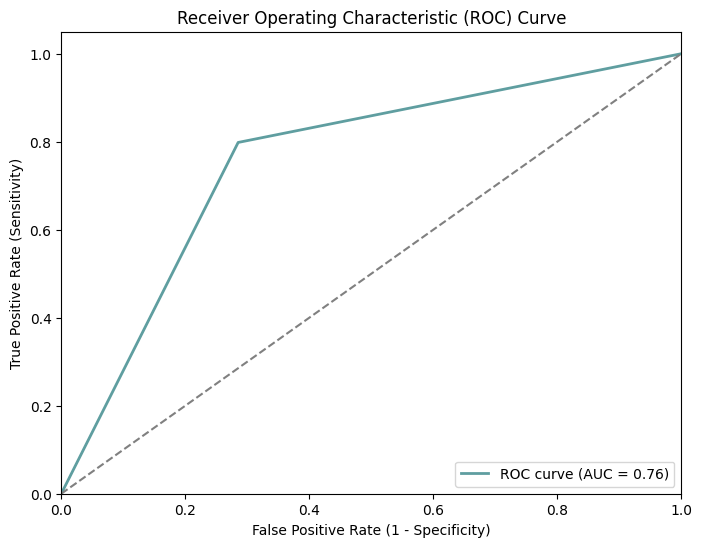

In [163]:
# ROC curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y, lr_y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='cadetblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [164]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)

scores = []
y_train_list = np.array(y_train)

for train_idx, val_idx in rskf.split(X_train, y_train):
    Xcross_train, ycross_train = X_train[train_idx], y_train_list[train_idx]
    X_val, y_val = X_train[val_idx], y_train_list[val_idx]
    
    lr_model_tuned.fit(Xcross_train, ycross_train)
    ycross_pred = lr_model_tuned.predict(X_val)
    
    scores.append(accuracy_score(ycross_pred, y_val))

print("Scores:", scores)
print("Mean =", np.mean(scores))

Scores: [0.7730496453900709, 0.723404255319149, 0.7428571428571429, 0.8214285714285714, 0.7642857142857142, 0.7659574468085106, 0.7730496453900709, 0.7714285714285715, 0.75, 0.7428571428571429, 0.75177304964539, 0.7588652482269503, 0.7571428571428571, 0.7571428571428571, 0.7714285714285715]
Mean = 0.7616447146234381


Using cross validation we ca see that the accuracy of our model is enhanced.

### Deep learning to achieve the goal

In [165]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

tf.random.set_seed(0)

# model architecture
tf_model = Sequential([
    Dense(64, activation='relu', input_shape=(7,)),
    Dense(80, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling the model
tf_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Training the model
tf_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = tf_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/10
22/22 [==============================] - 0s 4ms/step - loss: 0.6672 - accuracy: 0.5926 - val_loss: 0.6057 - val_accuracy: 0.7097
Epoch 2/10
22/22 [==============================] - 0s 1ms/step - loss: 0.5888 - accuracy: 0.7293 - val_loss: 0.5537 - val_accuracy: 0.7500
Epoch 3/10
22/22 [==============================] - 0s 1ms/step - loss: 0.5441 - accuracy: 0.7536 - val_loss: 0.5126 - val_accuracy: 0.7661
Epoch 4/10
22/22 [==============================] - 0s 1ms/step - loss: 0.5123 - accuracy: 0.7593 - val_loss: 0.4958 - val_accuracy: 0.7581
Epoch 5/10
22/22 [==============================] - 0s 3ms/step - loss: 0.4998 - accuracy: 0.7664 - val_loss: 0.4853 - val_accuracy: 0.7500
Epoch 6/10
22/22 [==============================] - 0s 1ms/step - loss: 0.4910 - accuracy: 0.7507 - val_loss: 0.4781 - val_accuracy: 0.7581
Epoch 7/10
22/22 [==============================] - 0s 1ms/step - loss: 0.4863 - accuracy: 0.7621 - val_loss: 0.4682 - val_accuracy: 0.7661
Epoch 8/10
22/22 [==

In [166]:
y_pred_rnn = tf_model.predict(X_scaled)

26/26 [==============================] - 0s 321us/step


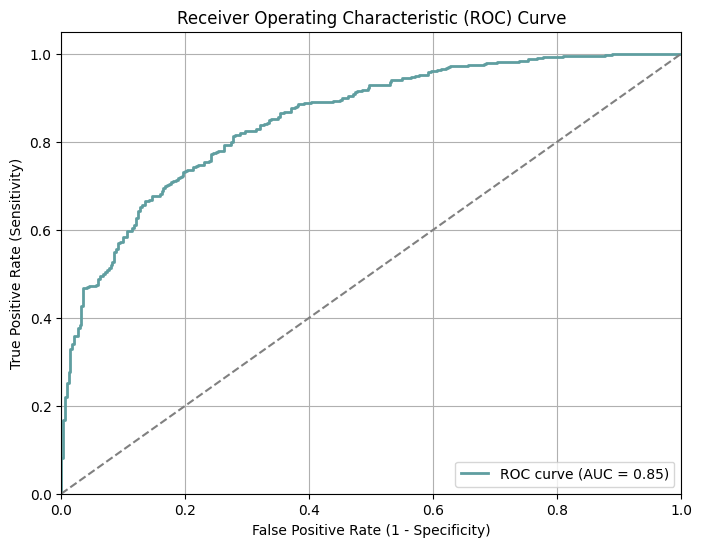

In [167]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix

# Compute ROC curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y, y_pred_rnn)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='cadetblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

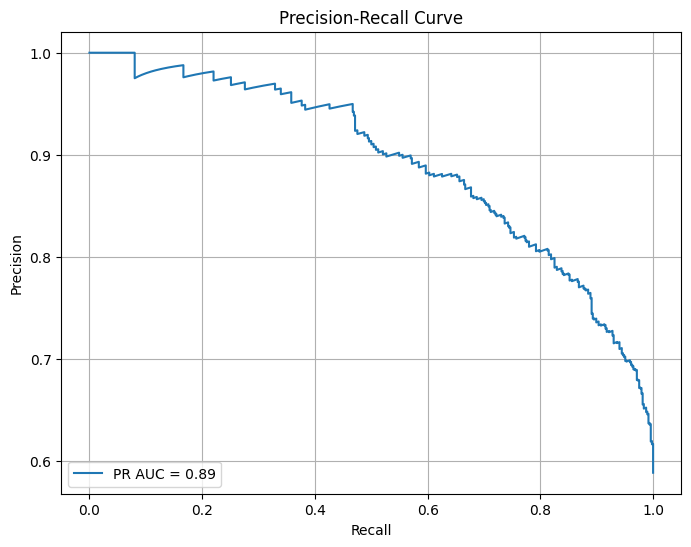

In [168]:
precision, recall, thresholds = precision_recall_curve(y, y_pred_rnn)

# Compute Area Under the Curve (AUC)
auc_score = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {auc_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [169]:
# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
threshold = 0.78
RNN_binary_predictions = [1 if prediction > threshold else 0 for prediction in y_pred_rnn.flatten()]

# Print the binary predictions
count_unknown(RNN_binary_predictions)

Number of unknown data (ones): 256
y dimension: 826
Ratio: 0.3099273607748184


In [170]:
confusion_matrix(RNN_binary_predictions, y)

array([[320, 250],
       [ 20, 236]])

In [171]:
print(classification_report(y, RNN_binary_predictions))

              precision    recall  f1-score   support

           0       0.56      0.94      0.70       340
           1       0.92      0.49      0.64       486

    accuracy                           0.67       826
   macro avg       0.74      0.71      0.67       826
weighted avg       0.77      0.67      0.66       826



In [172]:
print(classification_report(y, lr_y_pred))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       340
           1       0.80      0.80      0.80       486

    accuracy                           0.76       826
   macro avg       0.76      0.76      0.76       826
weighted avg       0.76      0.76      0.76       826



The deep learning model is overfitting, let's visualize other models to see if they are overfitting (for fun).

In [173]:
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=10)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
    plt.plot(train_sizes, valid_scores_mean, 'o-', label='Cross-validation score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title(f'Learning Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

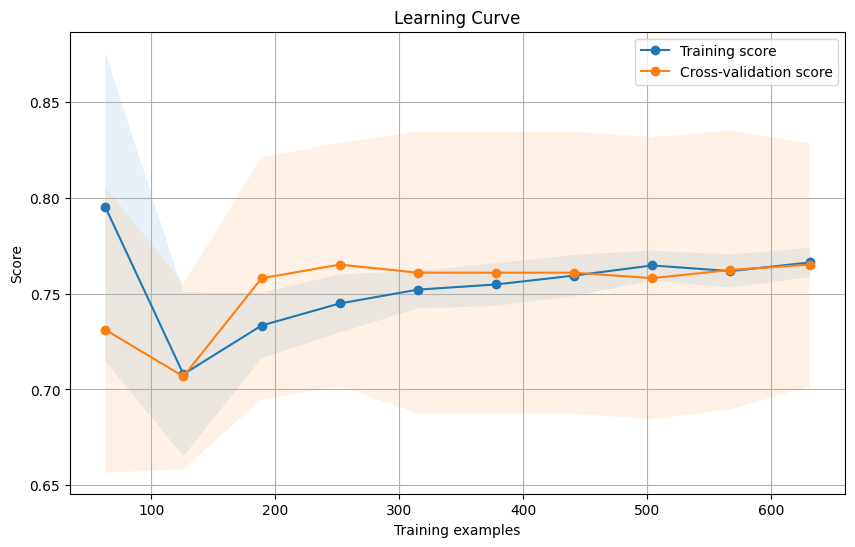

In [174]:
# Learning curve for model logistic regression model
plot_learning_curve(lr_model_tuned, X_train, y_train)

Tuned logistic regression model seems to be fitting data rapidly and in a good accuracy. The following models are overfitting.

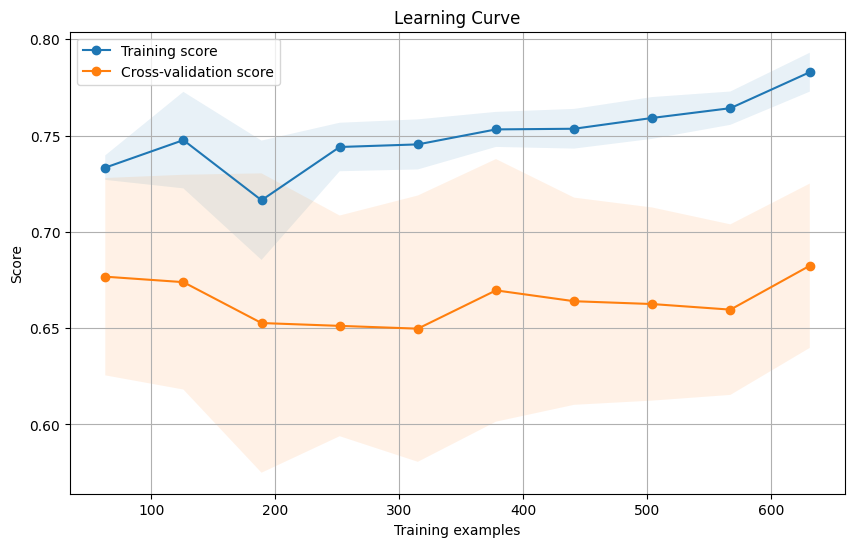

In [123]:
plot_learning_curve(knn_model, X_train, y_train)

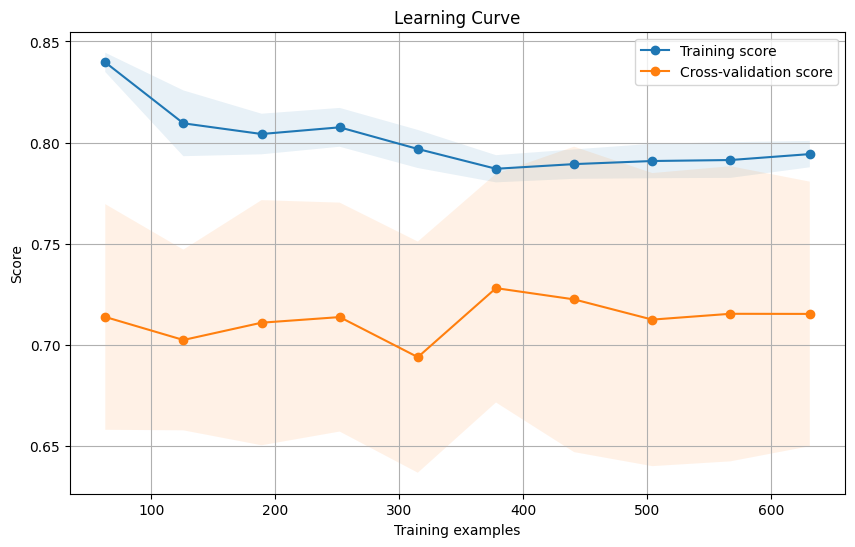

In [120]:
# Learning curve for SVC classifier
plot_learning_curve(svc_model, X_train, y_train)

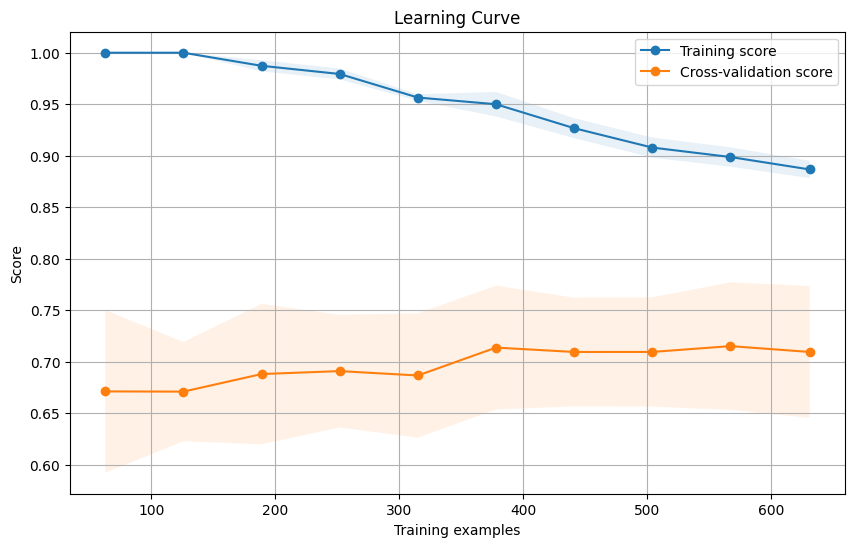

In [121]:
# Learning curve for Gradient Boosting Model
plot_learning_curve(gradient_boosting_model, X_train, y_train)

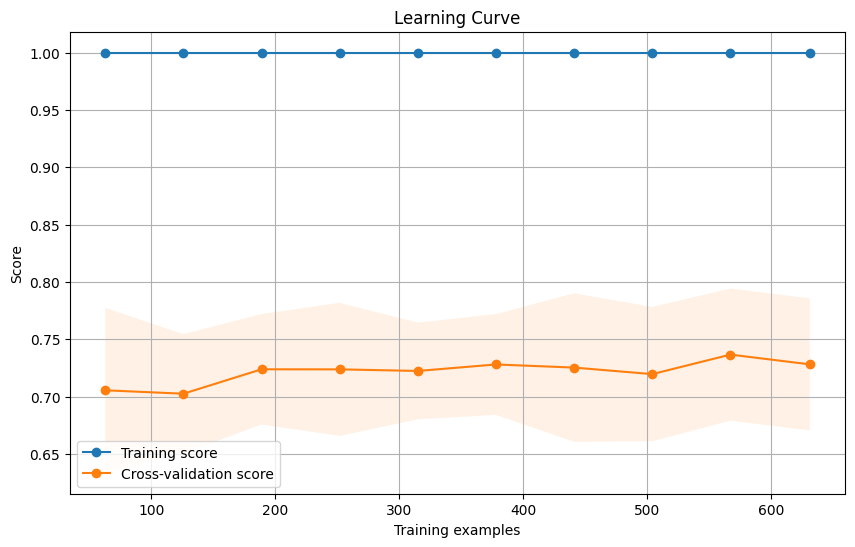

In [122]:
# Learning curve for Random Forest Model
plot_learning_curve(random_forest_model, X_train, y_train)

In [223]:
y_df = pd.DataFrame(lr_y_pred)
y_df.replace({1:'High', 0:'unknown'})
y_df.value_counts()

1    485
0    341
Name: count, dtype: int64

In [225]:
predictions_df = df_without_outliers.copy()
predictions_df.reset_index(drop=True, inplace=True)
predictions_df['LR_predictions'] = y_df.replace({1: 'High', 0: 'unknown'})
# predictions_df['SVC_predictions'] = label_encoder.inverse_transform(y_pred4)
# predictions_df['RNN_predictions'] = label_encoder.inverse_transform(RNN_binary_predictions)
predictions_df

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,LR_predictions
0,2,35.48,38.56,0.66,0.92,Potato,4,High,High
1,3,914.28,42.68,3.09,2.88,Breakfast,1,unknown,unknown
2,4,97.03,30.56,38.63,0.02,Beverages,4,High,unknown
3,5,27.05,1.85,0.80,0.53,Beverages,4,unknown,unknown
4,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High,High
...,...,...,...,...,...,...,...,...,...
821,942,186.21,83.94,1.98,22.40,Chicken,4,High,unknown
822,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,unknown,High
823,945,951.74,29.42,3.57,13.87,Pork,2,High,High
824,946,266.61,35.77,0.97,8.07,Potato,6,High,High


In [226]:
unknown_prediction = predictions_df[predictions_df['high_traffic']=='unknown']
high_predicted = unknown_prediction[unknown_prediction['LR_predictions']=='High']
high_predicted

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,LR_predictions
6,8,299.14,3.17,0.40,32.40,Lunch/Snacks,4,unknown,High
31,36,796.89,29.10,9.63,2.28,Lunch/Snacks,2,unknown,High
38,43,576.89,4.79,20.92,4.29,One Dish Meal,2,unknown,High
45,51,293.36,19.16,9.40,1.32,Pork,2,unknown,High
54,62,187.87,55.51,9.99,86.09,One Dish Meal,4,unknown,High
...,...,...,...,...,...,...,...,...,...
783,895,576.07,21.89,2.96,71.16,Pork,4,unknown,High
785,898,576.38,15.98,0.54,36.23,Pork,2,unknown,High
794,907,194.37,12.17,1.58,3.67,Lunch/Snacks,4,unknown,High
815,933,1017.32,85.12,1.71,1.85,Potato,1,unknown,High


Among 340 unknown traffic state (outliers truncated), we were able to predict 97 recipes that can lead to high traffic.

### 3.2. Model Fine Tuning Using Ensemble Methods

1. Bagging (Bootstrap Aggregating):

In [177]:
from sklearn.ensemble import BaggingClassifier

# Bagging with logistic_regression_model
bagging_lr = BaggingClassifier(base_estimator=lr_model_tuned, n_estimators=1000, random_state=0)
bagging_lr.fit(X_train, y_train)
lr_y_bagging = bagging_lr.predict(X_test)

# Bagging with SVC classifier
bagging_svc = BaggingClassifier(base_estimator=svc_model, n_estimators=100, random_state=0)
bagging_svc.fit(X_train, y_train)
svc_y_bagging = bagging_svc.predict(X_test)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [178]:
accuracy_score(lr_y_bagging, y_test)

0.7580645161290323

In [179]:
accuracy_score(svc_y_bagging, y_test)

0.7580645161290323

At least, we got the initial accuary of SVC classifier. But is it normal to get exactly the same accyracy for logistic regression even after testing for many values of n_estimators ?

2. Boosting

In [180]:
from sklearn.ensemble import AdaBoostClassifier

# Boosting with logistic_regression_model
lr_adaboost = AdaBoostClassifier(base_estimator=logistic_regression_model, n_estimators=1000, random_state=0)
lr_adaboost.fit(X_train, y_train)
lr_y_adaboost = lr_adaboost.predict(X_test)

# Boosting with SVC classier
# adaboost_svc = AdaBoostClassifier(base_estimator=svc_model, n_estimators=50, random_state=0)
# adaboost_svc.fit(X_train, y_train)
# y_adaboost_svc = adaboost_svc.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [181]:
accuracy_score(lr_y_adaboost, y_test)

0.7419354838709677

3. Stacking

In [182]:
from sklearn.ensemble import StackingClassifier

# first we define a meta-estimator
meta_estimator = LogisticRegression(random_state=0)

# Then we stack two models using this meta learner
estimators = [('LR', logistic_regression_model), ('SVC', svc_model)]
stacking = StackingClassifier(estimators=estimators, final_estimator=meta_estimator)

# Fit stacking classifier with corresponding subsets of training data
stacking.fit(X_train, y_train)  # Use X_train_req and y_train_req for logistic_regression_model_req
y_stacking = stacking.predict(X_test)
stacking_accuracy = accuracy_score(y_stacking, y_test)
stacking_accuracy

0.7580645161290323

In [183]:
stacking_predictions = stacking.predict(X_scaled)

In [184]:
print(classification_report(y, stacking_predictions))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       340
           1       0.80      0.80      0.80       486

    accuracy                           0.77       826
   macro avg       0.76      0.76      0.76       826
weighted avg       0.77      0.77      0.77       826



In [227]:
predictions_df['Stacking_predictions'] = pd.DataFrame(stacking_predictions).replace({1:'High', 0:'unknown'})
predictions_df

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,LR_predictions,Stacking_predictions
0,2,35.48,38.56,0.66,0.92,Potato,4,High,High,High
1,3,914.28,42.68,3.09,2.88,Breakfast,1,unknown,unknown,unknown
2,4,97.03,30.56,38.63,0.02,Beverages,4,High,unknown,unknown
3,5,27.05,1.85,0.80,0.53,Beverages,4,unknown,unknown,unknown
4,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High,High,High
...,...,...,...,...,...,...,...,...,...,...
821,942,186.21,83.94,1.98,22.40,Chicken,4,High,unknown,unknown
822,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,unknown,High,High
823,945,951.74,29.42,3.57,13.87,Pork,2,High,High,High
824,946,266.61,35.77,0.97,8.07,Potato,6,High,High,High
